In [3]:
import pandas as pd
# import pyarrow.parquet as pq
from numpy import nan
import numpy as np
import matplotlib.pyplot as plt

# Windmill Preprocessing
## Clean and prepare windmill data for GIS

In [ ]:
# static cols
cols = ['GSRN','Turbine_type','Parent_GSRN','BBR_municipal','Placement','UTM_x','UTM_y','Capacity_kw','Rotor_diameter','Navhub_height','Out_service']

In [ ]:
windmills = pd.read_parquet('data/ITU_DATA/masterdatawind.parquet', columns=cols)

In [ ]:
windmills

### Filter In_service from till now

In [ ]:
windmills = windmills[windmills['Out_service'].isna()]

In [ ]:
windmills

### Remove duplicated data
Windmills have duplicated data by different reviewers.    

In [ ]:
windmills.drop_duplicates(subset = "GSRN", keep = 'first', ignore_index = True, inplace = True)
windmills.shape

9168 Contains:    
- H: Household turbine : No UTM_xy locations 
- W: Single turbine : full data
- P: Turbine park : No UTM_xy locations
- M: Turbine in a park : No power record in settlement data


In [ ]:
print('Household: ',windmills[windmills['Turbine_type'] == 'H'].shape)
print('Single: ',windmills[windmills['Turbine_type'] == 'W'].shape)
print('Park: ',windmills[windmills['Turbine_type'] == 'P'].shape)
print('In a Park: ',windmills[windmills['Turbine_type'] == 'M'].shape)

Household has no coordinates, filter it out

In [ ]:
windmills = windmills[windmills['Turbine_type'] != 'H']
len(windmills)

### Fill Turbine park xy by calculate their CENTRIODs.

In [ ]:
aggs = {'UTM_x':lambda x : x.mean(),
        'UTM_y':lambda x : x.mean()}
w_temp = windmills[windmills['Turbine_type'] == 'M'].groupby(['Parent_GSRN'], as_index = False).agg(aggs).rename(columns={'Parent_GSRN':'GSRN','UTM_x':'x_c','UTM_y':'y_c'})
w_temp

In [ ]:
windmills = pd.merge(windmills, w_temp, on='GSRN', how='left')
# location
windmills[['UTM_x']] = windmills.apply(lambda x: x[['UTM_x']].fillna(value = x['x_c']), axis=1)[['UTM_x']]
windmills[['UTM_y']] = windmills.apply(lambda x: x[['UTM_y']].fillna(value = x['y_c']), axis=1)[['UTM_y']]
windmills = windmills.drop(columns=['x_c','y_c'])
windmills

In [ ]:
windmills = windmills.drop(columns = "Out_service")

Cause a bug in ArcGIS file import, we need to add a 'z' at the end of GSRN and Parent_GSRN

In [ ]:
windmills['GSRN'] = [x+'z' for x in windmills['GSRN']]
windmills['Parent_GSRN'].fillna('',inplace = True)
windmills['Parent_GSRN'] = [x+'z' for x in windmills['Parent_GSRN']]

In [ ]:
windmills.to_csv('data/windmills_gis.csv', index=False)

## After ArcGIS data extraction 
Merge data

In [ ]:
cols = ['GSRN','grid']
windmills_single_grid = pd.read_excel('data/windmills_to_single-grid.xlsx')[cols]
windmills_single_grid = windmills_single_grid.dropna(subset=["grid"]).reset_index(drop=True)
windmills_single_grid['grid'] = windmills_single_grid['grid'].astype(int)
windmills_single_grid['grid'] = windmills_single_grid['grid'].astype(str)
windmills = pd.merge(windmills, windmills_single_grid, on='GSRN', how='left')
windmills

In [ ]:
cols = ['GSRN','grid']
windmills_multi_grid = pd.read_excel('data/windmills_to_multi-grid.xlsx')[cols]
windmills_multi_grid = windmills_multi_grid.dropna(subset=["grid"]).reset_index(drop=True)
windmills_multi_grid['grid'] = windmills_multi_grid['grid'].astype(int)
windmills_multi_grid['grid'] = windmills_multi_grid['grid'].astype(str)

In [ ]:
def ab(df):
    return','.join(df.values)
    
windmills_multi_grid = windmills_multi_grid.groupby('GSRN')['grid'].apply(ab).reset_index().rename(columns={'grid':'grid_in_range'})
windmills = pd.merge(windmills, windmills_multi_grid, on='GSRN', how='left')
windmills

In [ ]:
cols = ['GSRN', 'Land_cover', 'Slope', 'Elevation']
windmills_gis_ext = pd.read_excel('data/windmills_lc_slope_ele.xlsx')[cols]

In [ ]:
roughness_dic = {210:0.0, 220:0.004, 200:0.005, 202:0.005, 140:0.03, 150:0.05, 11:0.1, 14:0.1, 130:0.1, 180:0.1, 10:0.1, 20:0.3, 30:0.3, 160:0.5, 120:0.5, 170:0.6, 190:1.0, 40:1.5, 50:1.5, 60:1.5, 70:1.5, 90:1.5, 100:1.5, 110:1.5, -1:0.0}
windmills_gis_ext['Roughness'] = windmills_gis_ext['Land_cover'].apply(lambda x: roughness_dic[x])
windmills_gis_ext

In [ ]:
windmills_gis_ext = windmills_gis_ext.astype({'GSRN':'str'})
windmills = pd.merge(windmills, windmills_gis_ext, on='GSRN', how='left')
windmills['Slope'] = round(windmills['Slope'],3)
windmills['Roughness'] = round(windmills['Roughness'],3)
windmills['Elevation'] = round(windmills['Elevation'],3)
windmills.fillna({'Slope':-1, 'Elevation':-1, 'Roughness':-1}, inplace=True)
windmills

### Save

In [ ]:
windmills['GSRN'] = windmills['GSRN'].apply(lambda x: x[0:len(x)-1])
windmills['Parent_GSRN'] = windmills['Parent_GSRN'].apply(lambda x: x[0:len(x)-1])

In [ ]:
windmills.to_csv('data/windmill_cleaned.csv',index=False)

# Filter Single and Parkark

In [18]:
windmill = pd.read_csv('data/windmill_cleaned.csv')

In [19]:
windmill = windmill[["GSRN", "Turbine_type", "Placement", "UTM_x", "UTM_y", "Capacity_kw", "Rotor_diameter", "Navhub_height", "grid", "Slope", "Elevation", "Roughness"]]
windmill = windmill[~windmill["UTM_x"].isnull()][~windmill["UTM_y"].isnull()][~windmill["grid"].isnull()][windmill["grid"] != 0]
windmill["grid"] = windmill["grid"].astype(int)
windmill["grid"] = windmill["grid"].astype(str)
windmill["Slope"] = windmill["Slope"].replace(-1, 0)
windmill["Elevation"] = windmill["Elevation"].replace(-1, 0)
windmill["Roughness"] = windmill["Roughness"].replace(-1, 0)
windmill = windmill[~windmill["Turbine_type"].isin(["H","M"])]
windmill.to_csv("data/windmill_cleaned_WP.csv", index=False)
windmill= windmill[["GSRN", "Turbine_type", "Placement", "UTM_x", "UTM_y", "Capacity_kw", "Rotor_diameter", "Navhub_height", "grid", "Slope", "Elevation", "Roughness"]]
windmill = windmill[~windmill["UTM_x"].isnull()][~windmill["UTM_y"].isnull()][windmill["grid"] != 0]
windmill["Slope"] = windmill["Slope"].replace(-1, 0)
windmill["Elevation"] = windmill["Elevation"].replace(-1, 0)
windmill["Roughness"] = windmill["Roughness"].replace(-1, 0)
windmill = windmill[~windmill["Turbine_type"].isin(["H","M"])]
windmill.to_csv("data/windmill_cleaned_WP.csv", index=False)
windmill

,GSRN,Turbine_type,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,grid,Slope,Elevation,Roughness
8,570714700000000102,W,LAND,717690.0,6167403.0,300.0,31.0,30.0,652,5.885,2.2,0.1
11,570714700000000133,W,LAND,719902.0,6167171.0,1000.0,50.0,55.0,652,1.432,2.0,1.0
12,570714700000000140,W,LAND,719970.0,6167337.0,660.0,47.0,40.0,652,0.000,2.0,0.0
13,570714700000000157,W,LAND,720031.0,6167484.0,660.0,47.0,40.0,652,0.000,2.0,1.5
28,570714700000000317,W,LAND,704171.0,6199826.0,660.0,47.0,40.0,696,0.000,21.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
6907,571313174001699894,W,LAND,644459.0,6073175.0,3600.0,126.0,87.0,771,0.000,1.0,0.1
6908,571313174001699900,W,LAND,644136.0,6073257.0,3600.0,126.0,87.0,771,1.432,1.0,0.1
6909,571313174001764448,W,LAND,702483.0,6132921.0,225.0,29.0,31.5,650,0.000,22.0,0.1
6910,571313174116253585,W,LAND,694932.0,6175477.0,850.0,52.0,44.0,736,1.432,12.8,0.1


# Observe Land and Single

In [20]:
windmill = pd.read_csv("data/windmill_cleaned_WP.csv")
len(windmill)

4356

In [21]:
windmill = windmill[windmill["Turbine_type"] == "W"][windmill["Placement"] == "LAND"]
len(windmill)

3907

## Capacity_kw distribution

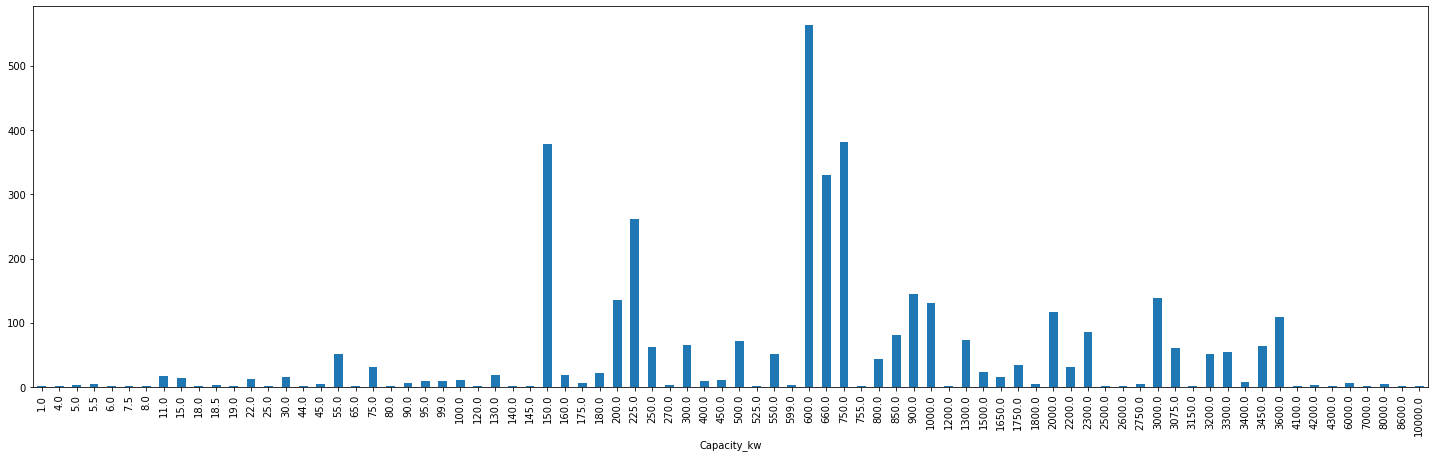

In [22]:
plt.figure(figsize=(25,7))
windmill.groupby("Capacity_kw").count()["GSRN"].plot.bar()

## Choose Capacity == 600

In [23]:
windmill_LW600 = windmill[windmill["Capacity_kw"] == 600]
len(windmill_LW600)

564

In [24]:
windmill_LW600.groupby(["Rotor_diameter", "Navhub_height", "Slope", "Elevation", "Roughness"])["GSRN"].count() \
                .reset_index(name='count') \
                .sort_values(['count'], ascending=False)

,Rotor_diameter,Navhub_height,Slope,Elevation,Roughness,count
379,44.0,46.0,0.000,0.000,0.1,6
380,44.0,46.0,0.000,1.000,0.1,5
179,44.0,35.0,0.000,0.000,0.1,4
185,44.0,35.0,0.000,5.000,0.1,3
64,43.0,40.0,0.000,0.000,0.1,3
...,...,...,...,...,...,...
168,43.0,50.0,1.432,57.500,0.1,1
167,43.0,50.0,1.013,25.702,0.1,1
166,43.0,50.0,1.013,23.000,0.1,1
165,43.0,50.0,1.013,19.000,0.1,1


## Select windmills with the same condition

In [25]:
windmills_exp = windmill_LW600[windmill_LW600["Rotor_diameter"] == 44.0][windmill_LW600["Navhub_height"] == 46.0][windmill_LW600["Slope"] == 0][windmill_LW600["Elevation"] == 0][windmill_LW600["Roughness"] == 0.1]

In [26]:
windmills_exp

,GSRN,Turbine_type,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,grid,Slope,Elevation,Roughness
2373,570715000000034374,W,LAND,453592.74,6184820.19,600.0,44.0,46.0,1321,0.0,0.0,0.1
2376,570715000000034404,W,LAND,453775.32,6184692.99,600.0,44.0,46.0,1321,0.0,0.0,0.1
2379,570715000000034435,W,LAND,453954.24,6184575.97,600.0,44.0,46.0,1321,0.0,0.0,0.1
2382,570715000000034466,W,LAND,454136.50,6184449.03,600.0,44.0,46.0,1321,0.0,0.0,0.1
2385,570715000000034497,W,LAND,454316.38,6184332.02,600.0,44.0,46.0,1321,0.0,0.0,0.1
2389,570715000000034534,W,LAND,454901.00,6184501.60,600.0,44.0,46.0,1279,0.0,0.0,0.1


In [27]:
windmills_exp.to_csv("data/windmills_same_cond.csv", index=False)